In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn.metrics import roc_auc_score, roc_curve, auc, log_loss, confusion_matrix
from sklearn.externals import joblib
import warnings
import itertools
import timeit

import pydotplus
from IPython.display import Image
from IPython.core.display import HTML 
from sklearn.externals.six import StringIO
from sklearn import tree

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [5]:
#read raw data
restaurant = pd.read_csv("DOHMH_New_York_City_Restaurant_Inspection_Results.csv", dtype = {'ZIPCODE':str, 'PHONE':str, 'CAMIS':str})

restaurant_new = restaurant.drop(['ACTION', 'VIOLATION CODE', 'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'INSPECTION TYPE'], axis=1)



In [181]:
restaurant

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE
0,41190258,KI SUSHI,BROOKLYN,122,SMITH STREET,11201,7189350575,Japanese,11/18/2014,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,Not Critical,20.0,NaN,NaN,02/02/2018,Cycle Inspection / Initial Inspection
1,40403857,S.M.R RESTAURANT SERVICES,QUEENS,4605,56 ROAD,11378,7183619826,American,06/01/2015,Violations were cited in the following area(s).,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,11.0,A,06/01/2015,02/02/2018,Cycle Inspection / Re-inspection
2,50072425,99 CENTS PIZZA & FRIES,MANHATTAN,2060,LEXINGTON AVE,10035,2127220708,Pizza,12/27/2017,Violations were cited in the following area(s).,20D,Choking first aid poster not posted. Alcohol...,Not Critical,NaN,NaN,NaN,02/02/2018,Administrative Miscellaneous / Initial Inspection
3,41176438,LAS CAMELIAS BAR & RESTAURANT,BRONX,1802,WESTCHESTER AVENUE,10472,7187941827,"Latin (Cuban, Dominican, Puerto Rican, South &...",04/11/2017,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,Not Critical,18.0,NaN,NaN,02/02/2018,Cycle Inspection / Initial Inspection
4,50003104,BEDFORD PIZZA CAFE,BRONX,380,BEDFORD PARK BLVD,10458,9178010770,Pizza/Italian,11/20/2015,Violations were cited in the following area(s).,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,18.0,B,11/20/2015,02/02/2018,Cycle Inspection / Re-inspection
5,50051616,TACOS SAN LUCAS,BRONX,1320A,JEROME AVE,10452,7184843198,Mexican,01/29/2018,Violations were cited in the following area(s).,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,24.0,NaN,NaN,02/02/2018,Cycle Inspection / Initial Inspection
6,40572406,SHAMROCK INN,BRONX,1729,CROSBY AVENUE,10461,7188228889,Irish,08/03/2016,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,Not Critical,32.0,C,08/03/2016,02/02/2018,Cycle Inspection / Re-inspection
7,40612915,LUCKY STAR RESTAURANT,BROOKLYN,13,MARCUS GARVEY BLVD,11206,7182189112,Caribbean,01/22/2015,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,Not Critical,13.0,A,01/22/2015,02/02/2018,Cycle Inspection / Initial Inspection
8,41623086,SING KEE SEAFOOD RESTAURANT,MANHATTAN,42,BOWERY,10013,2122338666,Chinese,04/23/2015,Violations were cited in the following area(s).,04M,Live roaches present in facility's food and/or...,Critical,23.0,NaN,NaN,02/02/2018,Cycle Inspection / Initial Inspection
9,41027331,CAFFE ITALIA,QUEENS,1240,CLINTON VILLE STREET,11357,7187674513,Bakery,12/08/2015,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,Not Critical,11.0,A,12/08/2015,02/02/2018,Cycle Inspection / Initial Inspection


In [182]:
restaurant.shape

(387752, 18)

In [ ]:
restaurant_new['t'] = restaurant_new['SCORE'].map(lambda x: 1 if x > 13 else 0)

data_mean = restaurant_new.groupby(['CAMIS', 'BORO', 'ZIPCODE', 'CUISINE DESCRIPTION'], as_index = False)[['t']].mean()

In [6]:
data_mean.shape

(26663, 5)

In [8]:
data_mean['target'] = data_mean['t'].map(lambda x: 1 if x >= 0.5 else 0)

data_mean_new = data_mean.drop(['t'], axis=1)

In [9]:
data_mean_new.groupby(['target']).count()

,CAMIS,BORO,ZIPCODE,CUISINE DESCRIPTION
target,,,,
0,16832,16832,16832,16832
1,9831,9831,9831,9831


In [12]:
data_lat_lng = pd.read_csv("data_lat_lng.csv", dtype = {'ZIPCODE':str, 'PHONE':str, 'CAMIS':str})

data_l_l = data_lat_lng[['CAMIS', 'latitude', 'longitude']]

data_v1 = pd.merge(data_mean_new, data_l_l, how='left', on=['CAMIS'])

In [13]:
data_v1.shape

(26663, 7)

In [14]:
data_v1.isnull().sum()

CAMIS                     0
BORO                      0
ZIPCODE                   0
CUISINE DESCRIPTION       0
target                    0
latitude               2614
longitude              2614
dtype: int64

In [15]:
data_v1.quantile([.01, 0.5, 0.99])
#Staten Island SW 40.495729, -74.247854, 
#Queens E 40.741905, -73.700941
#Brox N 40.915321, -73.910402

,target,latitude,longitude
0.01,0.0,40.564785,-74.164215
0.50,0.0,40.735066,-73.960689
0.99,1.0,40.882805,-73.743892


In [16]:
data_v1.loc[data_v1['latitude'] <40.495729]

,CAMIS,BORO,ZIPCODE,CUISINE DESCRIPTION,target,latitude,longitude
1006,40401834,MANHATTAN,10023,American,1,37.797607,-122.406560
1054,40402699,BRONX,10471,American,1,38.154145,-79.144061
2327,40752293,BROOKLYN,11206,Spanish,1,34.718996,-76.667857
6963,41391832,BRONX,10451,American,0,38.533657,-89.983662
6964,41391840,BRONX,10451,Steak,0,38.533657,-89.983662
7006,41395342,QUEENS,11368,"Ice Cream, Gelato, Yogurt, Ices",0,13.769571,100.627219
7007,41395345,QUEENS,11368,American,0,13.769571,100.627219
9594,41583720,MANHATTAN,10029,Vegetarian,1,39.629911,-90.456291
19144,50044992,MANHATTAN,10001,Donuts,0,18.580786,98.999492


In [17]:
data_v1.loc[data_v1['latitude'] <40.495729, 'latitude'] = None
data_v1.loc[data_v1['latitude'] <40.495729, 'longitude'] = None

In [18]:
data_v1.loc[data_v1['latitude'] >40.915321]

,CAMIS,BORO,ZIPCODE,CUISINE DESCRIPTION,target,latitude,longitude


In [19]:
data_v1.loc[data_v1['longitude'] <-74.3]

,CAMIS,BORO,ZIPCODE,CUISINE DESCRIPTION,target,latitude,longitude
1006,40401834,MANHATTAN,10023,American,1,NaN,-122.406560
1054,40402699,BRONX,10471,American,1,NaN,-79.144061
2327,40752293,BROOKLYN,11206,Spanish,1,NaN,-76.667857
6963,41391832,BRONX,10451,American,0,NaN,-89.983662
6964,41391840,BRONX,10451,Steak,0,NaN,-89.983662
9594,41583720,MANHATTAN,10029,Vegetarian,1,NaN,-90.456291


In [20]:
data_v1.loc[data_v1['longitude'] <-74.3, 'latitude'] = None
data_v1.loc[data_v1['longitude'] <-74.3, 'longitude'] = None

In [21]:
data_v1.loc[data_v1['longitude'] >-73.7]

,CAMIS,BORO,ZIPCODE,CUISINE DESCRIPTION,target,latitude,longitude
7006,41395342,QUEENS,11368,"Ice Cream, Gelato, Yogurt, Ices",0,NaN,100.627219
7007,41395345,QUEENS,11368,American,0,NaN,100.627219
19144,50044992,MANHATTAN,10001,Donuts,0,NaN,98.999492


In [22]:
data_v1.loc[data_v1['longitude'] >-73.7, 'latitude'] = None
data_v1.loc[data_v1['longitude'] >-73.7, 'longitude'] = None

In [25]:
fill_by_zip = data_v1.groupby(['ZIPCODE'])[['latitude', 'longitude']].mean()
lat_zip = fill_by_zip['latitude'].to_dict()
lon_zip = fill_by_zip['longitude'].to_dict()

data_v1['latitude_fillna'] = data_v1[['latitude']]

data_v1.loc[data_v1['latitude'].isnull(), 'latitude_fillna'] = data_v1.loc[data_v1['latitude'].isnull(), 'ZIPCODE'].map(lambda x: lat_zip[x])

data_v1['longitude_fillna'] = data_v1[['longitude']]
    
data_v1.loc[data_v1['longitude'].isnull(), 'longitude_fillna'] = data_v1.loc[data_v1['longitude'].isnull(), 'ZIPCODE'].map(lambda x: lon_zip[x])

In [26]:
data_v1.isnull().sum()

CAMIS                     0
BORO                      0
ZIPCODE                   0
CUISINE DESCRIPTION       0
target                    0
latitude               2623
longitude              2623
latitude_fillna           3
longitude_fillna          3
dtype: int64

In [27]:
data_v1.loc[data_v1['longitude_fillna'].isnull()]

,CAMIS,BORO,ZIPCODE,CUISINE DESCRIPTION,target,latitude,longitude,latitude_fillna,longitude_fillna
3934,41069646,BRONX,10510,Caribbean,1,NaN,NaN,NaN,NaN
16031,50016753,QUEENS,11352,Chinese,1,NaN,NaN,NaN,NaN
22574,50059227,QUEENS,11003,Other,0,NaN,NaN,NaN,NaN


In [29]:
fill_by_boro = data_v1.groupby(['BORO'])[['latitude', 'longitude']].mean()
lat_boro = fill_by_boro['latitude'].to_dict()
lon_boro = fill_by_boro['longitude'].to_dict()

data_v1.loc[data_v1['latitude_fillna'].isnull(), 'latitude_fillna'] = data_v1.loc[data_v1['latitude_fillna'].isnull(), 'BORO'].map(lambda x: lat_boro[x])

data_v1.loc[data_v1['longitude_fillna'].isnull(), 'longitude_fillna'] = data_v1.loc[data_v1['longitude_fillna'].isnull(), 'BORO'].map(lambda x: lon_boro[x])

In [30]:
data_v1.isnull().sum()

CAMIS                     0
BORO                      0
ZIPCODE                   0
CUISINE DESCRIPTION       0
target                    0
latitude               2623
longitude              2623
latitude_fillna           0
longitude_fillna          0
dtype: int64

In [33]:
data_v1['lat_scal'] = data_v1['latitude_fillna']

data_v1['lon_scal'] = data_v1['longitude_fillna']

data_v1[['lat_scal', 'lon_scal']] = minmax_scale(data_v1[['latitude_fillna', 'longitude_fillna']])

In [165]:
data_v1[['lat_scal', 'lon_scal']].describe()

,lat_scal,lon_scal
count,26663.000000,26663.000000
mean,0.546790,0.559439
std,0.167860,0.138336
min,0.000000,0.000000
25%,0.450015,0.475755
50%,0.560861,0.528453
75%,0.629664,0.632700
max,1.000000,1.000000


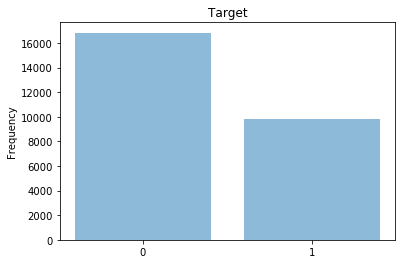

In [36]:
#generate binary class label:either A(0) or not(1)
y_tables = data_v1['target'].value_counts()
y_pos = np.arange(len(y_tables.values))
plt.bar(y_pos, y_tables.values, align='center', alpha=0.5)
plt.xticks(y_pos, list( y_tables.index))
plt.ylabel('Frequency')
plt.title('Target')
plt.show()

In [37]:
zipcode = pd.get_dummies(data_v1['ZIPCODE'], drop_first = True)

cusine = pd.get_dummies(data_v1['CUISINE DESCRIPTION'], drop_first = True)

model_data = pd.concat([data_v1['target'], data_v1['lat_scal'], data_v1['lon_scal'], cusine, zipcode], axis = 1)


#partition data 70% for modeling, 30% for holdout
Xtrain, Xhold, ytrain, yhold = train_test_split(model_data.drop(['target'], axis = 1), model_data['target'], test_size = 0.3, random_state = 42)

In [ ]:
#modeling starts

In [39]:
#Weighted regularized logistic regression
lr_estimator = LogisticRegression()
param_test = {'C':[0.1, 1, 100, 10000, 10000000], 'class_weight':[{1: 6}, {1: 5}, {1: 4}, {1: 3}, {1: 2}, {1: 1}]}
glr = GridSearchCV(lr_estimator, param_grid = param_test, refit = True, cv = 5, n_jobs = -1, scoring = 'roc_auc')
glr = glr.fit(Xtrain, ytrain)
blr = glr.best_estimator_

print (glr.best_params_)
lr_score = glr.best_score_
print ('roc_auc score: ', lr_score)

joblib.dump(blr, 'ori_lr.pkl')

{'C': 0.1, 'class_weight': {1: 1}}
roc_auc score:  0.641127427145


['ori_lr.pkl']

In [40]:
#KNeighbors Classifier
knn_estimator = KNeighborsClassifier()
param_test = {'n_neighbors':[5, 6, 7], 'weights':['uniform', 'distance']}
kn = GridSearchCV(knn_estimator, param_grid = param_test, refit = True, cv = 5, scoring = 'roc_auc', n_jobs = -1)
kn = kn.fit(Xtrain, ytrain)
bkn = kn.best_estimator_

print (kn.best_params_)
kn_score = kn.best_score_
print ('roc_auc score: ', kn_score)

joblib.dump(bkn, 'ori_kn.pkl')

{'n_neighbors': 6, 'weights': 'uniform'}
roc_auc score:  0.596279788209


['ori_kn.pkl']

In [42]:
#SVC Classifier
svc_estimator = SVC()
param_test = {'C':[10, 100, 1000]}
svc = GridSearchCV(svc_estimator, param_grid = param_test, refit = True, cv = 5, n_jobs = -1, scoring = 'roc_auc')
svc = svc.fit(Xtrain, ytrain)
bsvc = svc.best_estimator_

print (svc.best_params_)
svc_score = svc.best_score_
print ('roc_auc score: ', svc_score)

joblib.dump(bsvc, 'ori_svc.pkl')

{'C': 1000}
roc_auc score:  0.623343364443


['ori_svc.pkl']

In [130]:
#Tree-based model feature important list plot function
def plotFeatureImportance(tree_obj, n, features):
    importances = tree_obj.feature_importances_
    std = np.std([tree.feature_importances_ for tree in tree_obj.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(n):
        print((f + 1), features[indices[f]])

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    #plt.bar(range(n), importances[indices[:n]], color="r", yerr=std[indices[:n]], align="center")
    plt.bar(range(n), importances[indices[:n]], color="r", align="center")
    plt.xticks(range(n), features[indices[:n]], rotation=90)
    plt.xlim([-1,n])
    plt.show()
    return indices


In [43]:
#Random forest
rf_estimator1 = RandomForestClassifier(max_leaf_nodes = 200, min_samples_leaf = 10, min_samples_split = 2, n_estimators = 400, random_state = 1234, n_jobs = -1)
param_test = {'max_features': [0.2, 0.3, 0.4], 'min_samples_leaf': [5, 10, 15]}
grf1 = GridSearchCV(rf_estimator1, param_grid = param_test, refit =True, cv = 5, scoring = 'roc_auc', n_jobs = -1)
grf1 = grf1.fit(Xtrain, ytrain)
brf1 = grf1.best_estimator_

print (grf1.best_params_)
rf_score1 = grf1.best_score_
print ('roc_auc score: ', rf_score1)

joblib.dump(brf1, 'ori_rf1.pkl')

{'max_features': 0.2, 'min_samples_leaf': 10}
roc_auc score:  0.647173757462


['ori_rf1.pkl']

In [46]:
#Random forest cont'd finer tuning
start = timeit.default_timer()

rf_estimator2 = RandomForestClassifier(max_leaf_nodes = 200, min_samples_leaf = 10, min_samples_split = 2, n_estimators = 400, random_state = 1234, n_jobs = -1)
param_test = {'n_estimators': [275, 280, 290], 'max_features': [0.1, 0.15, 0.2]}
grf2 = GridSearchCV(rf_estimator2, param_grid = param_test, refit = True, cv = 5, scoring = 'roc_auc', n_jobs = -1)
grf2 = grf2.fit(Xtrain, ytrain)
brf2 = grf2.best_estimator_

print (grf2.best_params_)
rf_score2 = grf2.best_score_
print ('roc_auc score: ', rf_score2)

joblib.dump(brf2, 'ori_rf2.pkl')

stop = timeit.default_timer()
print ('run time: ', stop - start)

{'max_features': 0.15, 'n_estimators': 275}
roc_auc score:  0.648065103491
run time:  204.32877783753815


Feature ranking:
1 Other
2 lon_scal
3 lat_scal
4 Donuts
5 CafÃ©/Coffee/Tea
6 Latin (Cuban, Dominican, Puerto Rican, South & Central American)
7 Sandwiches
8 Spanish
9 American
10 Chinese
11 Japanese
12 Caribbean
13 Sandwiches/Salads/Mixed Buffet
14 Ice Cream, Gelato, Yogurt, Ices
15 Hamburgers
16 10121
17 Korean
18 Salads
19 Asian
20 Pizza/Italian
21 Juice, Smoothies, Fruit Salads
22 Mexican
23 Delicatessen
24 Indian
25 10013
26 Thai
27 Chicken
28 African
29 11368
30 Bakery


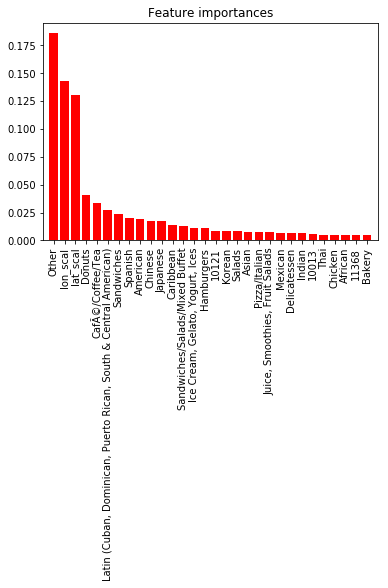

In [131]:
#final random forest model feature important plot
rf_indices = plotFeatureImportance(brf2, 30, np.array(Xtrain.columns.values))

In [53]:
#Extremely randomized tree
et_estimator1 = ExtraTreesClassifier(max_leaf_nodes = 200, min_samples_leaf = 10, min_samples_split = 2, n_estimators = 400, random_state = 1234, n_jobs = -1)
param_test = {'max_features': [0.2, 0.3, 0.4], 'min_samples_leaf': [5, 10, 15]}
get1 = GridSearchCV(et_estimator1, param_grid = param_test, refit =True, cv = 5, scoring = 'roc_auc', n_jobs = -1)
get1 = get1.fit(Xtrain, ytrain)
bet1 = get1.best_estimator_

print (get1.best_params_)
et_score1 = get1.best_score_
print ('roc_auc score: ', et_score1)

joblib.dump(bet1, 'ori_et1.pkl')

{'max_features': 0.2, 'min_samples_leaf': 10}
roc_auc score:  0.641293867038


['ori_et1.pkl']

In [58]:
##Extremely randomized tree cont'd finer tuning

et_estimator2 = ExtraTreesClassifier(max_leaf_nodes = 200, min_samples_leaf = 10, min_samples_split = 2, n_estimators = 400, random_state = 1234, n_jobs = -1)
param_test = {'n_estimators': [275, 280, 285], 'max_features': [0.02, 0.05, 0.1]}
get2 = GridSearchCV(et_estimator2, param_grid = param_test, refit = True, cv = 5, scoring = 'roc_auc', n_jobs = -1)
get2 = get2.fit(Xtrain, ytrain)
bet2 = get2.best_estimator_

print (get2.best_params_)
et_score2 = get2.best_score_
print ('roc_auc score: ', et_score2)

joblib.dump(bet2, 'ori_et2.pkl')



{'max_features': 0.05, 'n_estimators': 280}
roc_auc score:  0.643137216152


['ori_et2.pkl']

Feature ranking:
1 Other
2 Donuts
3 CafÃ©/Coffee/Tea
4 Latin (Cuban, Dominican, Puerto Rican, South & Central American)
5 Sandwiches
6 Spanish
7 Japanese
8 Caribbean
9 Chinese
10 American
11 Sandwiches/Salads/Mixed Buffet
12 Asian
13 10121
14 Hamburgers
15 Korean
16 Ice Cream, Gelato, Yogurt, Ices
17 lon_scal
18 Salads
19 Pizza/Italian
20 Delicatessen
21 Indian
22 Mexican
23 lat_scal
24 African
25 11220
26 11368
27 Juice, Smoothies, Fruit Salads
28 10009
29 10013
30 11234


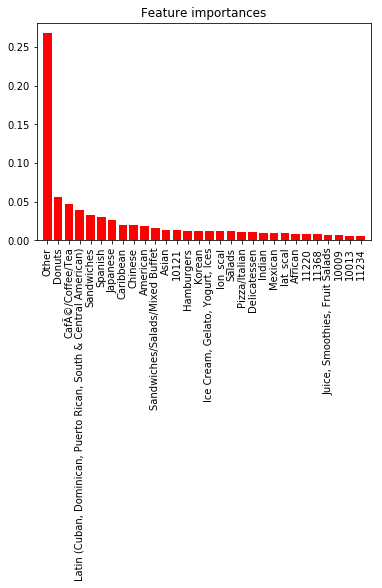

In [66]:
#final extremely randomized tree model feature important plot
et_indices = plotFeatureImportance(bet2, 30, np.array(Xtrain.columns.values))

In [100]:
#xgboost
xgb_estimator1 = XGBClassifier(max_depth = 5, min_child_weight = 7, colsample_bytree = 0.8, subsample = 0.8, n_estimators = 200, gamma = 0, colsample_bylevel = 1, learning_rate=0.01, objective= 'binary:logistic', random_state =1234, n_jobs = -1)
param_test = {'max_depth': range(4,11,2), 'min_child_weight': [range(4,9,2)]}
gxgb1 = GridSearchCV(xgb_estimator1, param_grid = param_test, refit = True, cv = 5, scoring = 'roc_auc', n_jobs = -1)
gxgb1 = gxgb1.fit(Xtrain, ytrain)
bxgb1 = gxgb1.best_estimator_

print (gxgb1.best_params_)
xgb_score1 = gxgb1.best_score_
print ('roc_auc score: ', xgb_score1)

joblib.dump(bxgb1, 'ori_xgb1.pkl')
      

{'max_depth': 10, 'min_child_weight': 8}
roc_auc score:  0.644004911773


['ori_xgb1.pkl']

In [101]:
#xgboost cont'd finer tuning
xgb_estimator2 = XGBClassifier(max_depth = 5, min_child_weight = 7, colsample_bytree = 0.8, subsample = 0.8, n_estimators = 200, gamma = 0, colsample_bylevel = 1, learning_rate=0.01, objective= 'binary:logistic', random_state =1234, n_jobs = -1)
param_test = {'max_depth': [10, 11], 'min_child_weight': [8, 9]}
gxgb2 = GridSearchCV(xgb_estimator2, param_grid = param_test, refit = True, cv = 5, scoring = 'roc_auc', n_jobs = -1)
gxgb2 = gxgb2.fit(Xtrain, ytrain)
bxgb2 = gxgb2.best_estimator_

print (gxgb2.best_params_)
xgb_score2 = gxgb2.best_score_
print ('roc_auc score: ', xgb_score2)

joblib.dump(bxgb2, 'ori_xgb2.pkl')

{'max_depth': 10, 'min_child_weight': 8}
roc_auc score:  0.644004911773


['ori_xgb2.pkl']

In [102]:
#xgboost cont'd finer tuning
xgb_estimator3 = XGBClassifier(max_depth = 10, min_child_weight = 8, colsample_bytree = 0.8, subsample = 0.8, n_estimators = 200, gamma = 0, colsample_bylevel = 1, learning_rate=0.01, objective= 'binary:logistic', random_state =1234, n_jobs = -1)
param_test = {'gamma':[i/10.0 for i in range(0,5)]}
gxgb3 = GridSearchCV(xgb_estimator3, param_grid = param_test, refit = True, cv = 5, scoring = 'roc_auc', n_jobs = -1)
gxgb3 = gxgb3.fit(Xtrain, ytrain)
bxgb3 = gxgb3.best_estimator_

print (gxgb3.best_params_)
xgb_score3 = gxgb3.best_score_
print ('roc_auc score: ', xgb_score3)

joblib.dump(bxgb3, 'ori_xgb3.pkl')

{'gamma': 0.0}
roc_auc score:  0.644004911773


['ori_xgb3.pkl']

In [108]:
#xgboost cont'd finer tuning
#calibrate the best number of round(n_estimator) with early-stopping enabled
xgb_param = bxgb3.get_xgb_params()
dm_train = xgb.DMatrix(Xtrain, label = ytrain)
cvresult = xgb.cv(xgb_param, dm_train, num_boost_round=400, nfold=5, metrics='auc', early_stopping_rounds=50)
print (cvresult.shape[0])

252


In [109]:
#xgboost cont'd finer tuning
xgb_estimator4 = XGBClassifier(max_depth = 10, min_child_weight = 8, colsample_bytree = 0.8, subsample = 0.8, n_estimators = 252, gamma = 0, colsample_bylevel = 1, learning_rate=0.01, objective= 'binary:logistic', random_state =1234, n_jobs = -1)
param_test = {'subsample':[i/10.0 for i in range(6,10)], 'colsample_bytree':[i/10.0 for i in range(6,10)]}
gxgb4 = GridSearchCV(xgb_estimator4, param_grid = param_test, refit = True, cv = 5, scoring = 'roc_auc', n_jobs = -1)
gxgb4 = gxgb4.fit(Xtrain, ytrain)
bxgb4 = gxgb4.best_estimator_

print (gxgb4.best_params_)
xgb_score4 = gxgb4.best_score_
print ('roc_auc score: ', xgb_score4)

joblib.dump(bxgb4, 'ori_xgb4.pkl')

{'colsample_bytree': 0.9, 'subsample': 0.6}
roc_auc score:  0.645702925483


['ori_xgb4.pkl']

In [110]:
#xgboost cont'd finer tuning
xgb_estimator5 = XGBClassifier(max_depth = 10, min_child_weight = 8, colsample_bytree = 0.9, subsample = 0.6, n_estimators = 252, gamma = 0, colsample_bylevel = 1, learning_rate=0.01, objective= 'binary:logistic', random_state =1234, n_jobs = -1)
param_test = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
gxgb5 = GridSearchCV(xgb_estimator5, param_grid = param_test, refit = True, cv = 5, scoring = 'roc_auc', n_jobs = -1)
gxgb5 = gxgb5.fit(Xtrain, ytrain)
bxgb5 = gxgb5.best_estimator_

print (gxgb5.best_params_)
xgb_score5 = gxgb5.best_score_
print ('roc_auc score: ', xgb_score5)

joblib.dump(bxgb5, 'ori_xgb5.pkl')

{'reg_alpha': 1}
roc_auc score:  0.645926572333


['ori_xgb5.pkl']

In [111]:
#xgboost cont'd finer tuning
#calibrate the best number of round(n_estimator) with early-stopping enabled

xgb_param = bxgb5.get_xgb_params()
cvresult = xgb.cv(xgb_param, dm_train, num_boost_round=600, nfold=5, metrics='auc', early_stopping_rounds=50)
print (cvresult.shape[0])

482


In [112]:
#xgboost cont'd finer tuning according to early-stop enabled best number_of_boost_round

xgb_estimator6 = XGBClassifier(max_depth = 10, min_child_weight = 8, reg_alpha = 1, colsample_bytree = 0.9, subsample = 0.6, n_estimators = 482, gamma = 0, colsample_bylevel = 1, learning_rate=0.01, objective= 'binary:logistic', random_state =1234, n_jobs = -1)
param_test = {'n_estimators':range(462, 503, 5)}
gxgb6 = GridSearchCV(xgb_estimator6, param_grid = param_test, refit = True, cv = 5, scoring = 'roc_auc', n_jobs = -1)
gxgb6 = gxgb6.fit(Xtrain, ytrain)
bxgb6 = gxgb6.best_estimator_

print (gxgb6.best_params_)
xgb_score6 = gxgb6.best_score_
print ('roc_auc score: ', xgb_score6)

joblib.dump(bxgb6, 'ori_xgb6.pkl')

{'n_estimators': 497}
roc_auc score:  0.647281254538


['ori_xgb6.pkl']

In [135]:
#xgboost specific feature important list plot function
#xgboost usage is different from other sklearn tree based models in this aspect
def plotFeatureImportance_xgb(xgb, n):
    imp = pd.DataFrame.from_dict(bxgb.get_fscore(), 'index').reset_index()
    imp.columns = ['feature','importance']
    importances = imp.sort_values('importance', ascending=False)
    indices = np.array(importances.index)
    importances = importances.reset_index(drop=True)
    total = importances['importance'].sum()
    importances['importance'] = importances['importance']/total
    # Print the feature ranking
    print("Feature ranking:")
    n = min(n, importances.shape[0])
    
    for f in range(n):
        print((f + 1), importances['feature'][f])

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(n), importances['importance'][:n], color="r",  align="center")
    plt.xticks(range(n), importances['feature'][:n], rotation=90)
    plt.xlim([-1,n])
    plt.show()
    return indices

Feature ranking:
1 lat_scal
2 lon_scal
3 Other
4 Donuts
5 CafÃ©/Coffee/Tea
6 Sandwiches
7 American
8 Latin (Cuban, Dominican, Puerto Rican, South & Central American)
9 Sandwiches/Salads/Mixed Buffet
10 Ice Cream, Gelato, Yogurt, Ices
11 Spanish
12 Hamburgers
13 10121
14 Salads
15 Caribbean
16 Japanese
17 Juice, Smoothies, Fruit Salads
18 Korean
19 Chinese
20 Asian
21 11375
22 Delicatessen
23 11213
24 10031
25 11355
26 11354
27 African
28 Indian
29 Chicken
30 Pizza/Italian


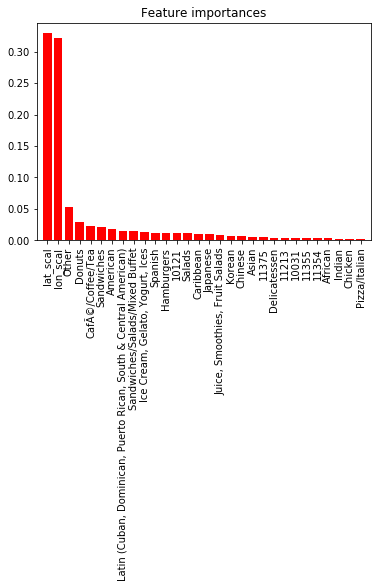

In [115]:
#final xgboost model feature important plot; 
#use the best hyperparameters which are tuned by sklearn xgboost API; 
#however, need to use these best hyper parameters to re-run the model using xgboost libarary directly to enable feature importance
params = bxgb6.get_xgb_params()
xgb = xgb.train(params, dm_train, num_boost_round= params['n_estimators'], verbose_eval = False)
xgbindices = plotFeatureImportance_xgb(xgb, 30) 


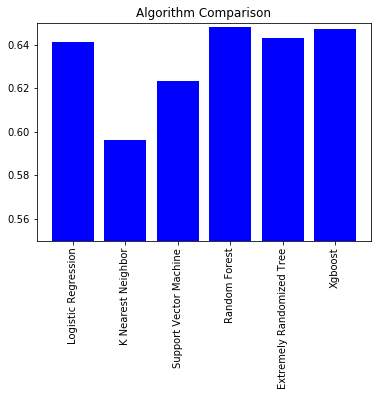

In [173]:
#models comparison
models = []
models.append(('Logistic Regression', lr_score))
models.append(('K Nearest Neighbor', kn_score))
models.append(('Support Vector Machine', svc_score))
models.append(('Random Forest', rf_score2))
models.append(('Extremely Randomized Tree', et_score2))
models.append(('Xgboost', xgb_score6))
results = []
names = []
for name, model in models:
    results.append(model)
    names.append(name)

plt.figure()
plt.title("Algorithm Comparison")
plt.bar(range(6), results, color="b",  align="center")
plt.xticks(range(6), names, rotation=90)
plt.ylim(0.55, 0.65)
plt.show()
#random forest is the best model to select

In [178]:
#model performance util functions
def plotLabel(ax):
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('Receiver operating characteristic')
        ax.legend(loc="lower right")



def make_com_roc_curve(g_ypred_pro, yh, g_model):        
        fpr = []
        tpr = []
        roc_auc = []
        n = len(g_ypred_pro)
        for i in range(n):
            ypred_pro1 = g_ypred_pro[i]
            fpr1, tpr1, _ = roc_curve(yh, ypred_pro1[:, 1])
            roc_auc1 = auc(fpr1, tpr1)
            fpr.append(fpr1)
            tpr.append(tpr1)
            roc_auc.append(roc_auc1)
    
        #plt.figure()
        fig, ax = plt.subplots(figsize=(6,6))
        lw = 2
        color = ['red', 'darkorange', 'green']
        for i in range(n):
            
            ax.plot(fpr[i], tpr[i], color=color[i], lw=lw, label= g_model[i] + ' ROC curve (area = %0.2f)' % roc_auc[i])
        
        ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plotLabel(ax)
    
        plt.show()

def plotcm(fig, ax, cm, classes, model = '', normalize = False, cmap=plt.cm.Blues):
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            title = model + " Normalized Confusion Matrix"
        else:
            title = model + ' Confusion Matrix'

        img = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.set_title(title)
        fig.colorbar(img, ax=ax)
        #tick_marks = np.arange(len(classes))
        ax.set_xticks(classes) #, rotation=45)
        ax.set_yticks(classes)
        #ax.set_xticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            #color="red" if cm[i, j] > thresh else "black")
            color="red")
        
        ax.set_ylabel('True label')
        ax.set_xlabel('Predicted label')
        
    
def make_confusion_matrix(ypred, yh, model = ""):
        cnf_matrix = confusion_matrix(yh, ypred)
        
        np.set_printoptions(precision=2)
        classes = list(np.unique(yh))
        
        
        #plt.figure()
        fig, (ax1, ax2)= plt.subplots(ncols=2, figsize=(12, 6))
        plotcm(fig, ax1, cnf_matrix, classes, model, False)
        #plt.figure()
        plotcm(fig, ax2, cnf_matrix, classes, model, True)
        
        
        plt.tight_layout()
        plt.show()


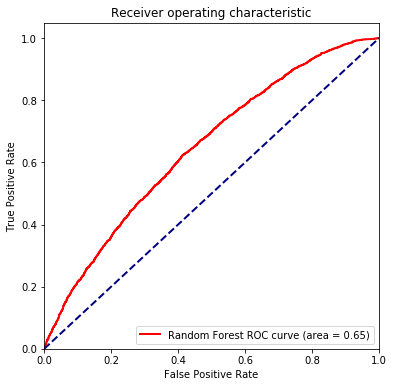

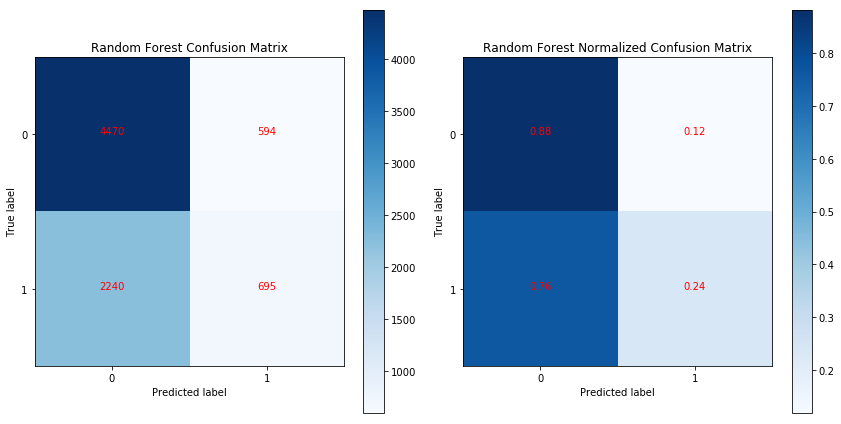

In [180]:
#test on holdout with the selected best model -- Random_Forest
model = 'Random Forest'        
ypred_pro = brf2.predict_proba(Xhold)
ypred = brf2.predict(Xhold)


make_com_roc_curve([ypred_pro], yhold, [model]) 
make_confusion_matrix(ypred, yhold, model = model)

In [154]:
#brf2 random forest classifier has 275 trees; only save 5 trees
i_tree = 1
features = Xtrain.columns.values
for tree_in_forest in brf2.estimators_:
        dot_data = StringIO() 
        tree.export_graphviz(tree_in_forest, out_file=dot_data, feature_names=features, class_names = True, filled = True)  
        graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
        if i_tree>5:
            break
        graph.write_png('RFtree_' + str(i_tree)+'.png')
        i_tree = i_tree + 1
        

# one example of tree from random forest
<img src="RFtree_1.png" style="height:auto">